In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [24]:
weather_df = pd.read_csv('/content/delhi_temperature.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_df.head()

,temperature
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0


In [25]:
weather_df.dtypes

temperature    float64
dtype: object

In [26]:
weather_df.index.dtype
#<M8[ns] is a specific dtype of datetime

dtype('<M8[ns]')

In [27]:
#weather_df.index = pd.to_datetime(weather_df.index)
weather_df.index

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 12:00:00',
               '1996-11-01 13:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 19:00:00',
               '1996-11-01 20:00:00', '1996-11-01 21:00:00',
               ...
               '2017-04-23 15:00:00', '2017-04-23 18:00:00',
               '2017-04-23 21:00:00', '2017-04-24 00:00:00',
               '2017-04-24 03:00:00', '2017-04-24 06:00:00',
               '2017-04-24 09:00:00', '2017-04-24 12:00:00',
               '2017-04-24 15:00:00', '2017-04-24 18:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=100990, freq=None)

In [28]:
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    percent = percent*100

    print('Count of missing data : \n',total)
    print('% of missing data : \n',percent)

list_and_visualize_missing_data(weather_df)

Count of missing data : 
 temperature    673
dtype: int64
% of missing data : 
 temperature    0.666403
dtype: float64


In [29]:
#Fill missing data with forward fill
weather_df.fillna(weather_df.mean())
print('Count of missing data : ',weather_df[weather_df.isnull()].count())

Count of missing data :  temperature    0
dtype: int64


In [30]:
weather_df.describe()

,temperature
count,100317.000000
mean,25.451269
std,8.482859
min,1.000000
25%,19.000000
50%,27.000000
75%,32.000000
max,90.000000


In [31]:
#since max temperature 90 is unrealistic, we treat them as outliers and thus remove them
weather_df = weather_df[weather_df.temperature < 50]
weather_df.describe()

,temperature
count,100313.000000
mean,25.449423
std,8.477692
min,1.000000
25%,19.000000
50%,27.000000
75%,32.000000
max,47.000000


In [32]:
weather_df.head()

,temperature
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0


array([<Axes: xlabel='datetime_utc'>], dtype=object)

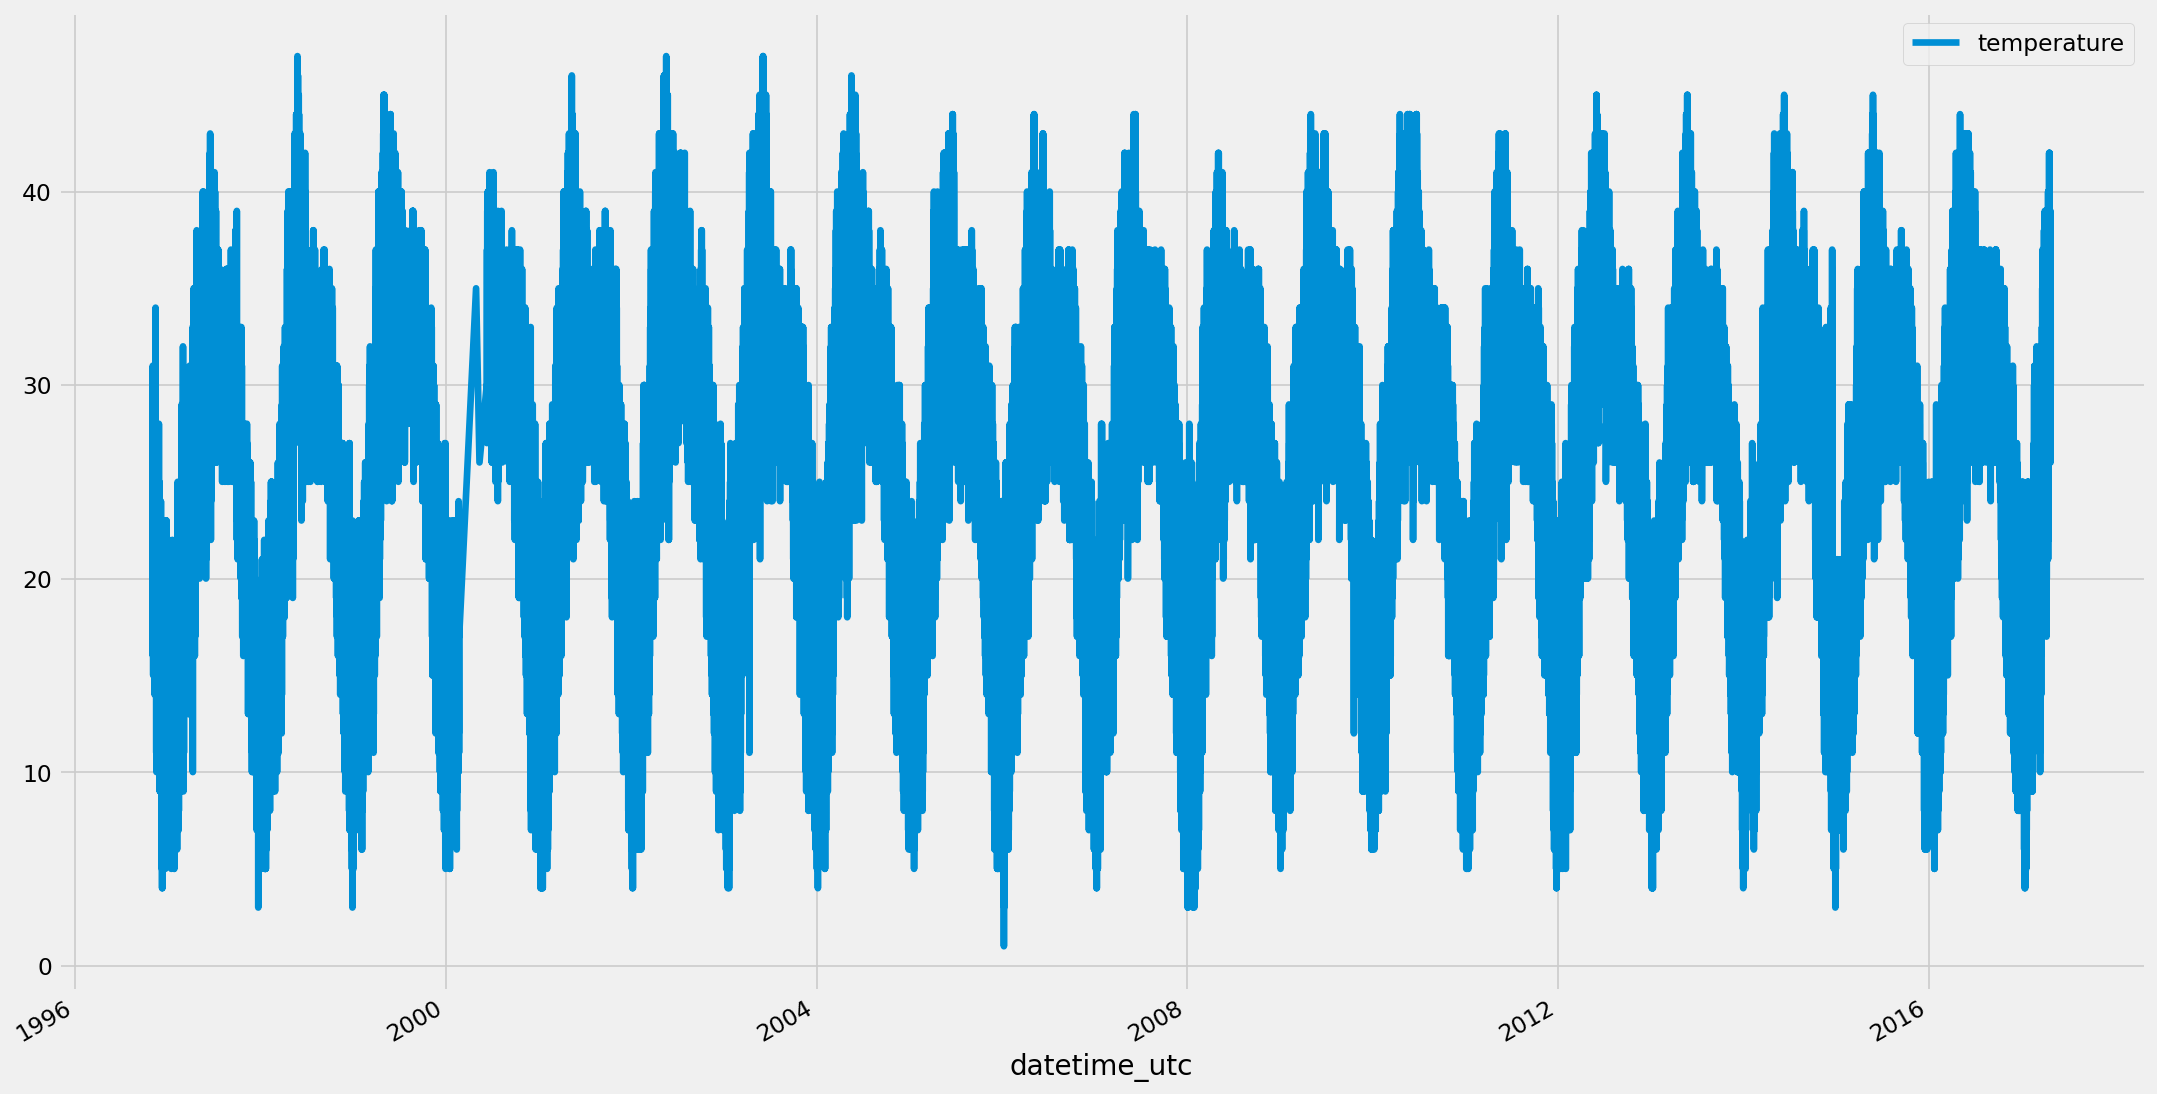

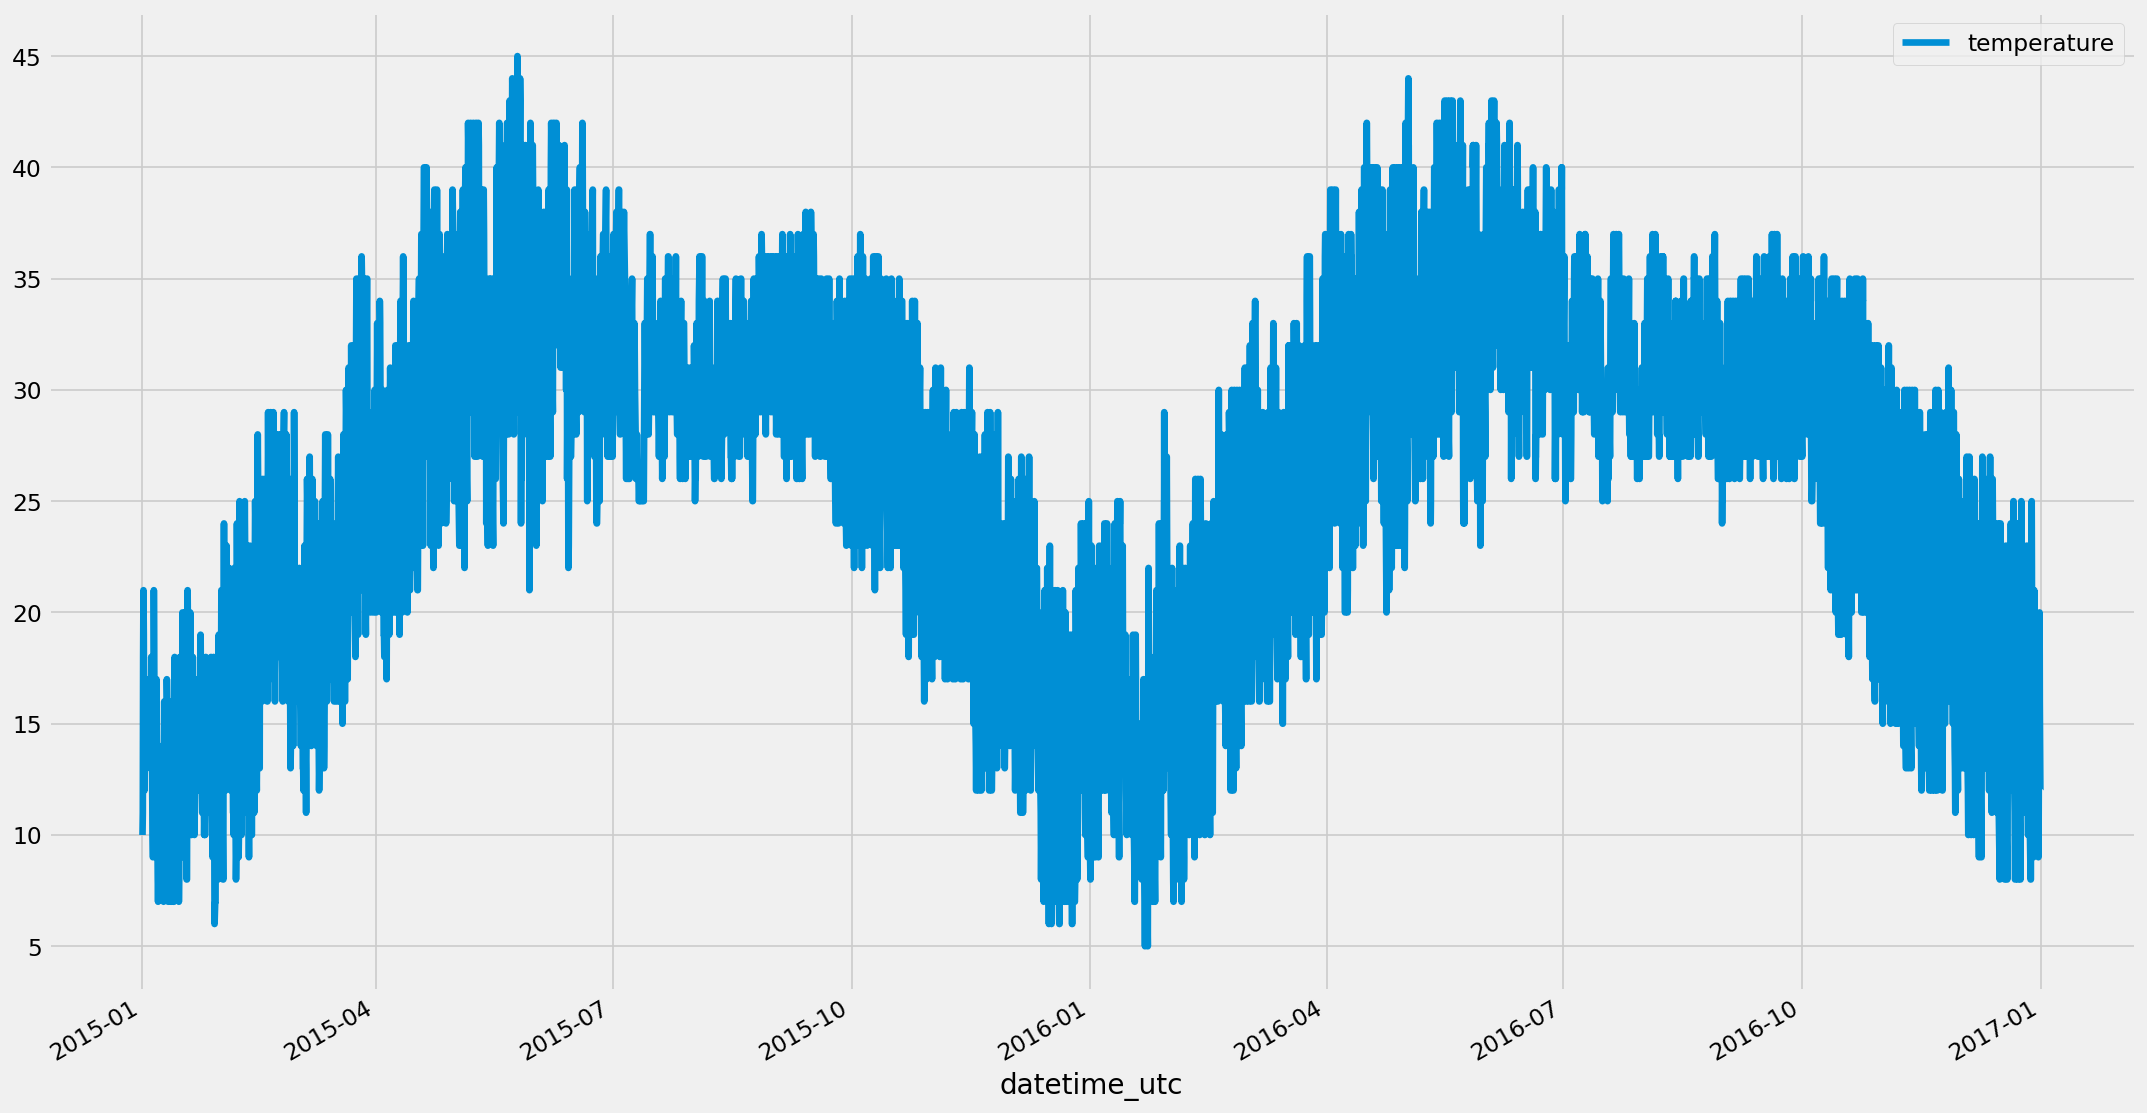

In [33]:
#check trend and seasonality of weather data
weather_df.plot(subplots=True, figsize=(20,12))
#detailed view of 2015 year
weather_df['2015':'2016'].resample('D')
weather_df['2015':'2016'].fillna(weather_df['2015':'2016']['temperature'].mean())
weather_df['2015':'2016'].plot(subplots=True, figsize=(20,12))

In [34]:
#split dataset into training and testing data
train_df = weather_df['2000':'2015'].resample('M').mean()
train_df = train_df.fillna(train_df.mean())
test_df = weather_df['2016':'2017'].resample('M').mean()
test_df = test_df.fillna(test_df.mean())

In [35]:
train_df.head()

,temperature
datetime_utc,
2000-01-31,13.730321
2000-02-29,14.991361
2000-03-31,25.218702
2000-04-30,35.000000
2000-05-31,26.000000


In [36]:
train_df.describe()

,temperature
count,192.000000
mean,25.218702
std,6.996585
min,11.805596
25%,18.801327
50%,27.752567
75%,30.929005
max,36.138095


In [37]:
test_df.head()

,temperature
datetime_utc,
2016-01-31,15.007752
2016-02-29,19.524297
2016-03-31,25.696391
2016-04-30,32.557987
2016-05-31,34.750000


In [38]:
test_df.describe()

,temperature
count,16.000000
mean,25.884703
std,6.920397
min,15.007752
25%,19.246738
50%,27.330739
75%,31.136869
max,34.940529


In [39]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

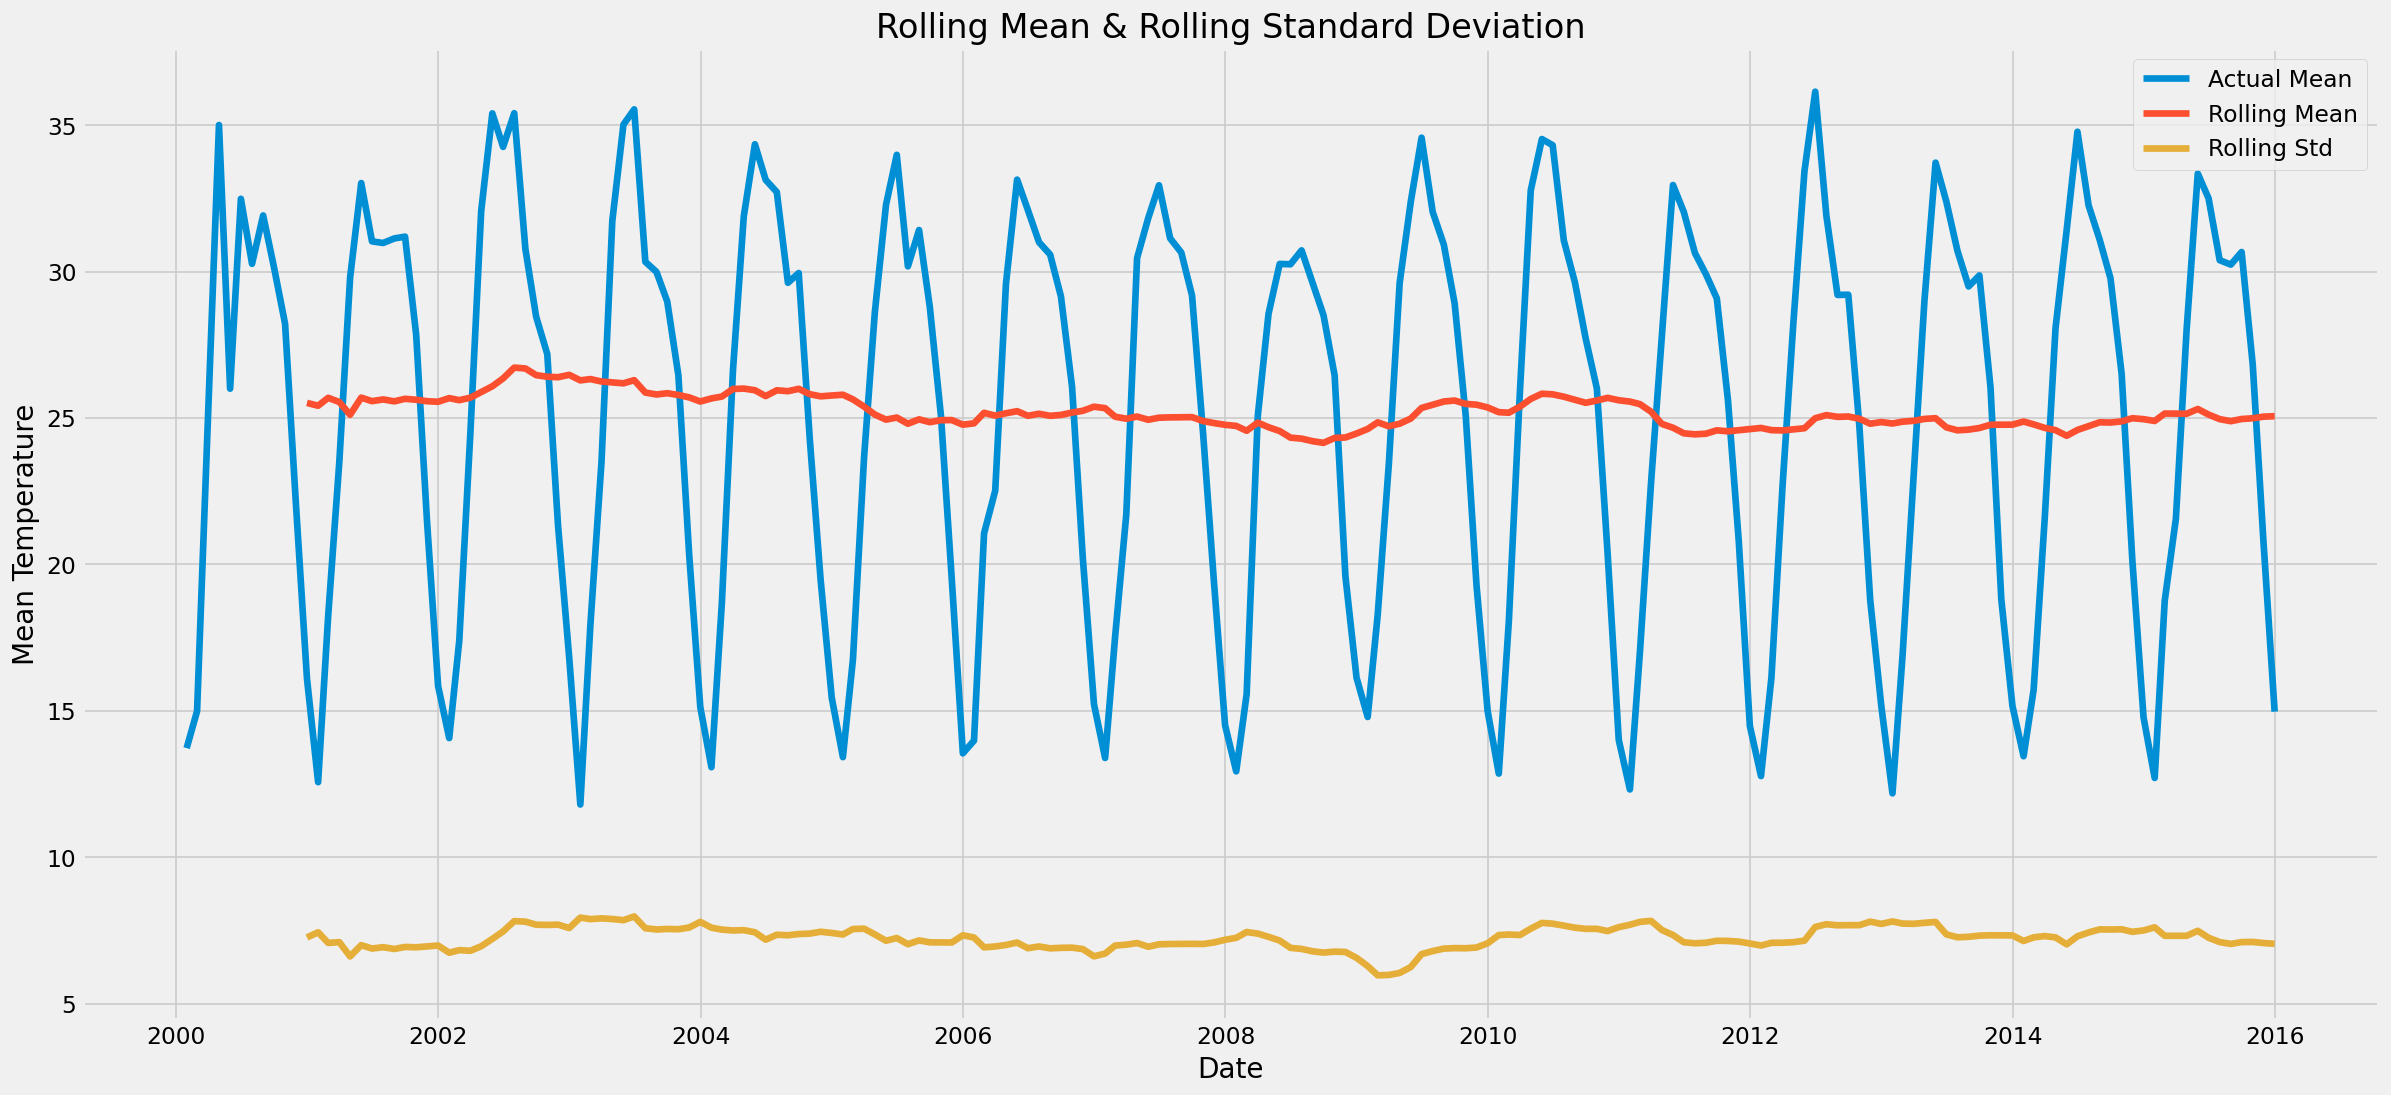

In [40]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(train_df.temperature)

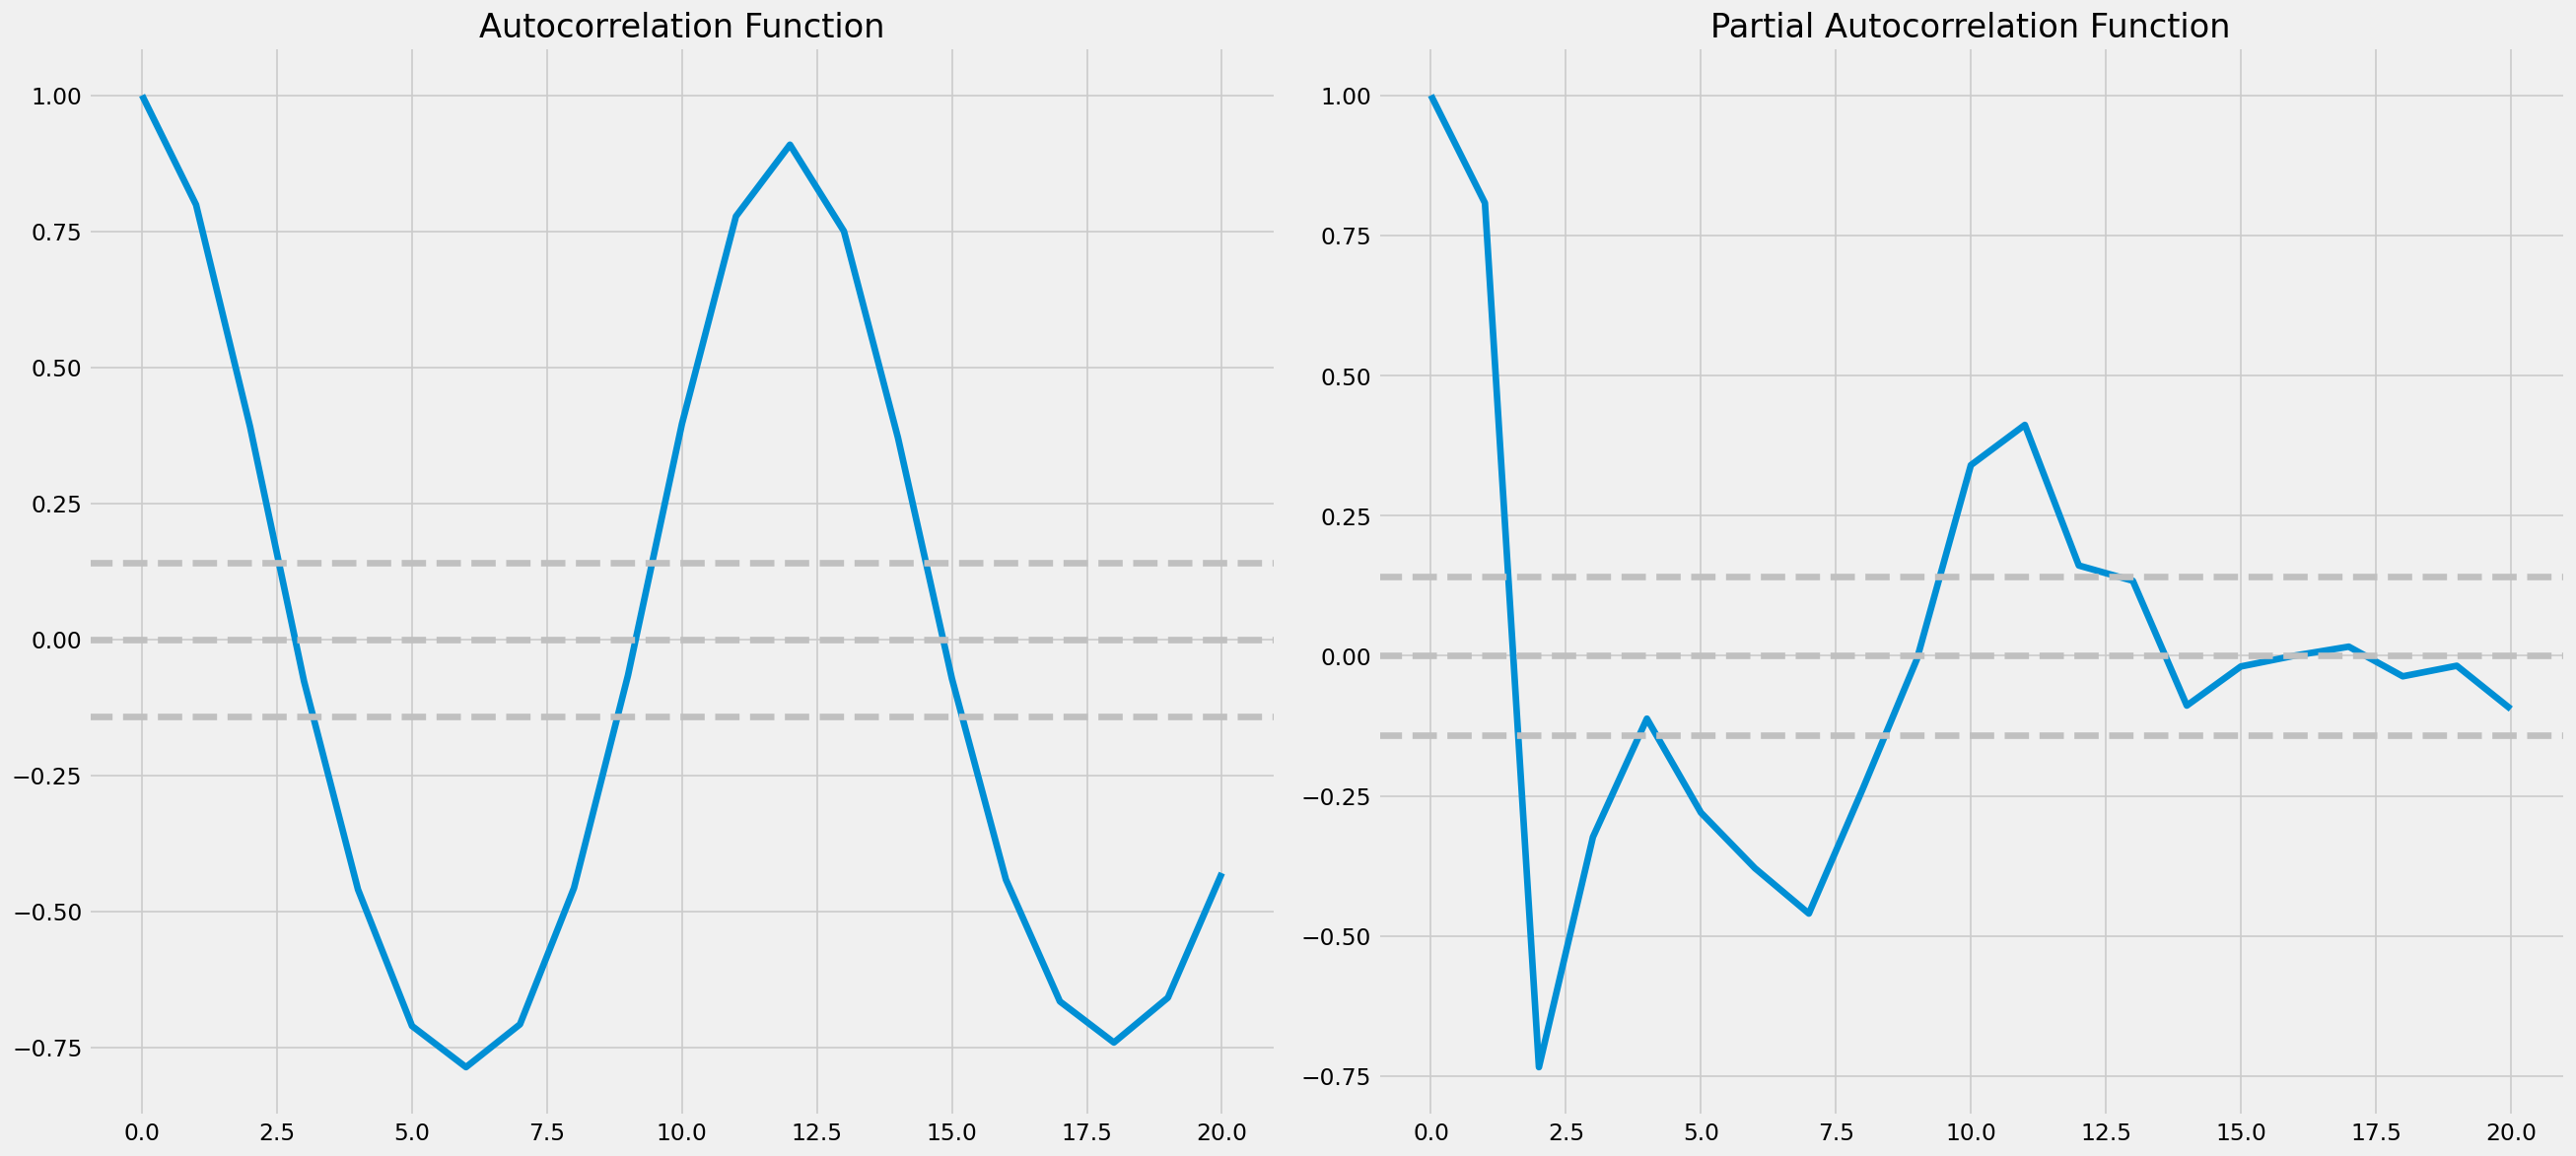

In [41]:
#Plot ACF and PACF
acf_lag = acf(train_df.values, nlags=20)
pacf_lag = pacf(train_df.values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(1,2,1)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(1,2,2)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [43]:
#ARIMA model

model = ARIMA(train_df.values, order=(1, 0, 5))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  192
Model:                 ARIMA(1, 0, 5)   Log Likelihood                -463.945
Date:                Mon, 15 Jul 2024   AIC                            943.891
Time:                        16:02:00   BIC                            969.950
Sample:                             0   HQIC                           954.445
                                - 192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1591      0.167    150.246      0.000      24.831      25.487
ar.L1          0.7037      0.075      9.403      0.000       0.557       0.850
ma.L1          0.3719      0.068      5.433      0.0

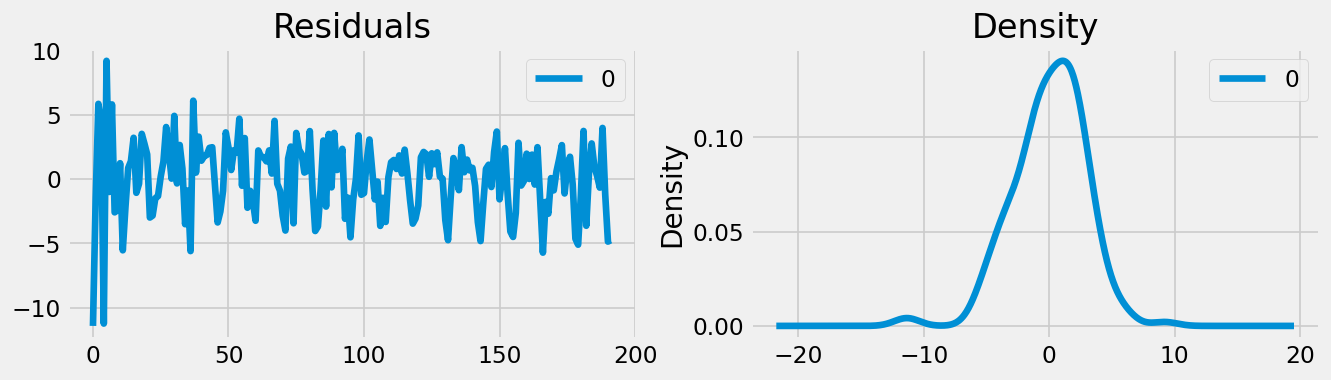

In [44]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

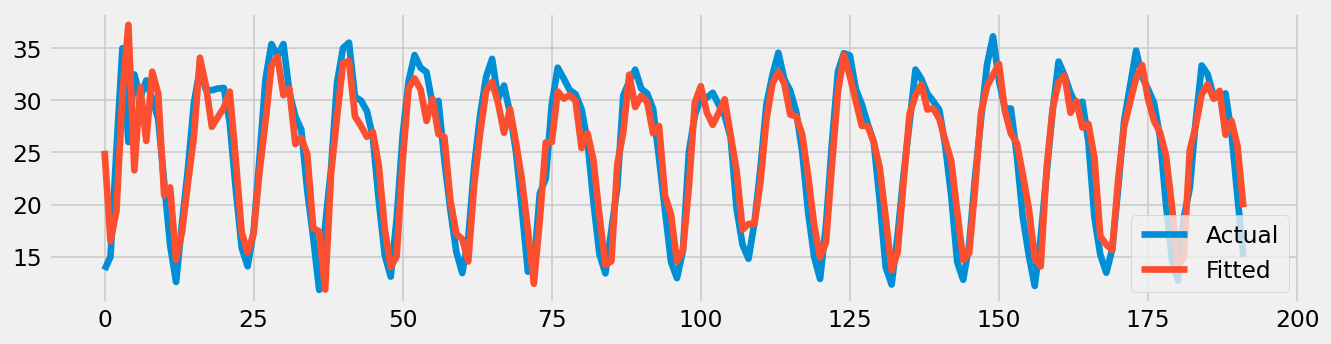

In [48]:
predictions = model_fit.predict()

plt.plot(train_df.values, label='Actual')
plt.plot(predictions, label='Fitted')
plt.legend()
plt.show()

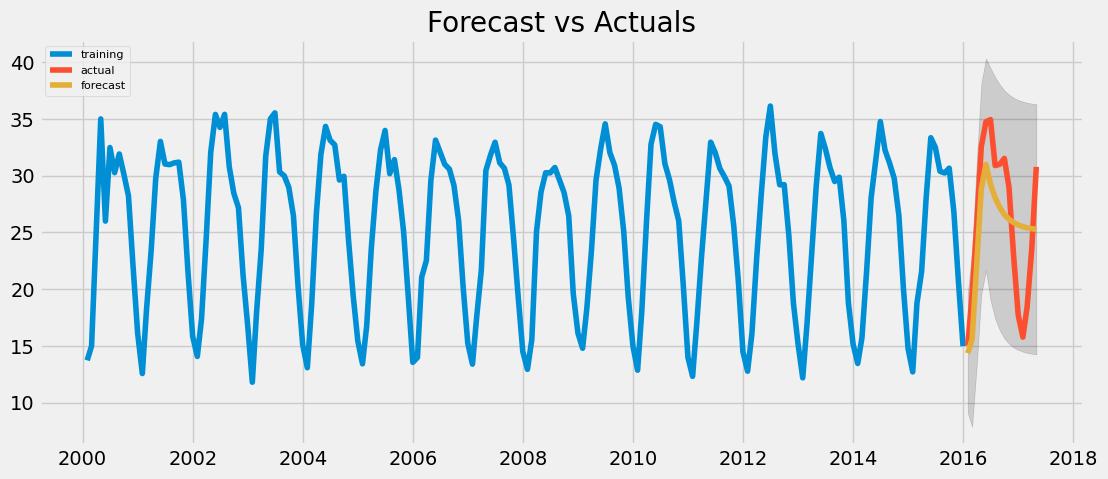

In [53]:
# # Forecast values for test_df
forecast_result = model_fit.get_forecast(16)  # Use get_forecast() instead of forecast()
fc = forecast_result.predicted_mean
se = forecast_result.se_mean
conf = forecast_result.conf_int()

# Make as pandas series
fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)  # Use array slicing instead of .iloc
upper_series = pd.Series(conf[:, 1], index=test_df.index)  # Use array slicing instead of .iloc

# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

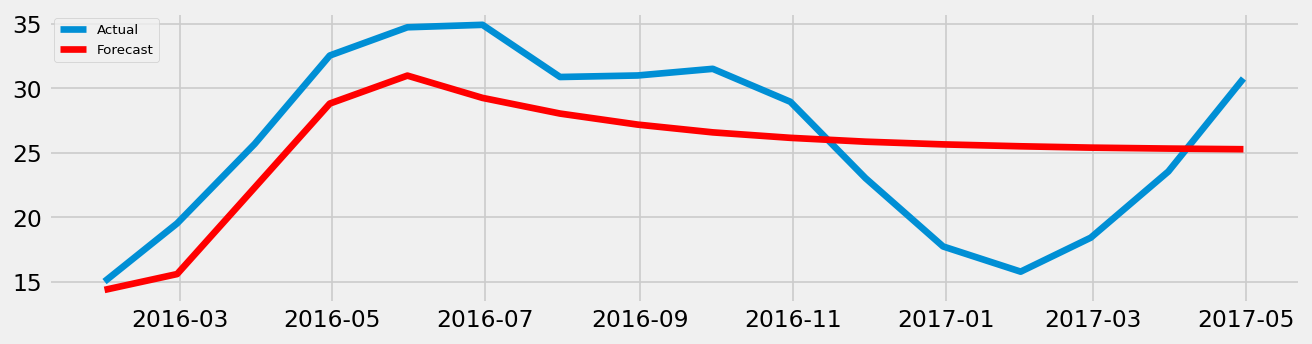

In [54]:
# plot Testing and Forecasted data
plt.plot(test_df, label='Actual')
plt.plot(fc_series, label='Forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [55]:
error = mean_squared_error(test_df, fc_series)
print('Test Mean Squared Error: ',error)

Test Mean Squared Error:  24.381755795888992
